# Image Classification with CNNs using Keras

# Task 1: Import Libraries

In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? False


# Task 2: Preprocess Data

In [2]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Task 3: Visualize Examples

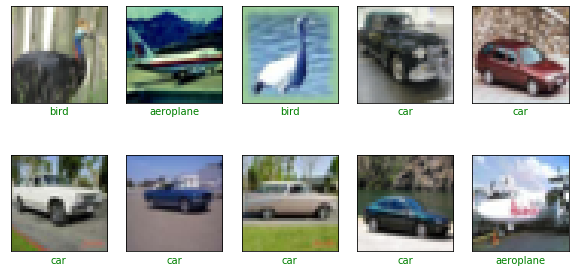

In [4]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_train, y_train, y_train)

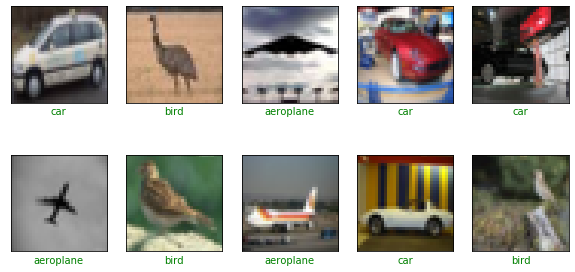

In [5]:
show_random_examples(x_test, y_test, y_test)

# Task 4: Create Model

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    
    def add_conv_block(model, num_filters):
        
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu', padding='valid'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.2))

        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)

    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

# Task 5: Train the Model

In [7]:
%%time

h = model.fit(
    x_train/255., y_train,
    validation_data=(x_test/255., y_test),
    epochs=10, batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
    ]
)

Train on 15000 samples, validate on 3000 samples
Epoch 1/10
15000/15000 [==============================] - 71s 5ms/sample - loss: 0.6511 - accuracy: 0.7527 - val_loss: 2.3151 - val_accuracy: 0.5027
Epoch 2/10
15000/15000 [==============================] - 76s 5ms/sample - loss: 0.4213 - accuracy: 0.8335 - val_loss: 2.2427 - val_accuracy: 0.4867
Epoch 3/10
15000/15000 [==============================] - 74s 5ms/sample - loss: 0.3554 - accuracy: 0.8628 - val_loss: 1.4781 - val_accuracy: 0.5213
Epoch 4/10
15000/15000 [==============================] - 71s 5ms/sample - loss: 0.2960 - accuracy: 0.8853 - val_loss: 0.6519 - val_accuracy: 0.7690
Epoch 5/10
15000/15000 [==============================] - 73s 5ms/sample - loss: 0.2630 - accuracy: 0.8997 - val_loss: 0.2726 - val_accuracy: 0.8953
Epoch 6/10
15000/15000 [==============================] - 72s 5ms/sample - loss: 0.2273 - accuracy: 0.9129 - val_loss: 0.4334 - val_accuracy: 0.8563
Epoch 7/10
15000/15000 [==============================] -

# Task 6: Final Predictions

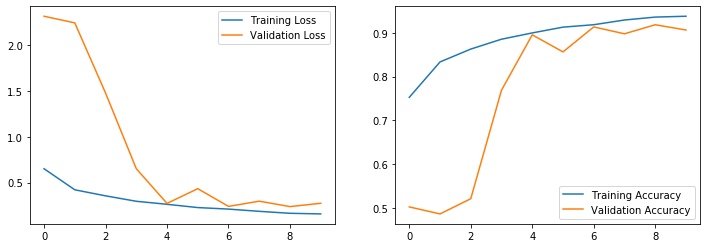

In [8]:
losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [9]:
model = tf.keras.models.load_model('models/model_0.913.h5')
preds = model.predict(x_test/255.)

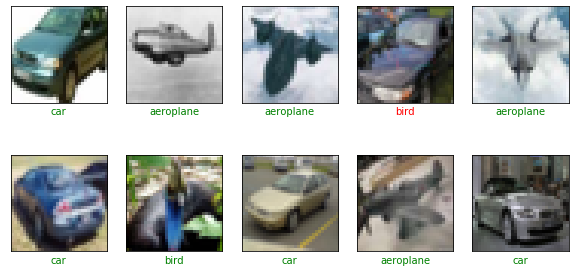

In [12]:
show_random_examples(x_test, y_test, preds)